## Step 1 | GAN/Imports



In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output
import os


## Step 2 importing the images


In [ ]:
#Replace the path replaced with Xs with the directory that the data file is stored in. 
#I added os.get_cwd() so people on different platforms can find the different formats of paths and adapt them to find the data.
# I reshaped all the photos into 100 by 100 pixels.
#and created a show_image function just to make sure everything is working properly.

import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(y/(1-y))
%matplotlib inline
path = '/home/leesalem/code/AliSalem2/data-challenges/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/data/Abstract_gallery'

os.getcwd()
img_list = os.listdir(path)
def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        img = Image.open(path+'/'+img_list[i],'r')
        basewidth = 100
        img = img.resize((basewidth,basewidth), Image.ANTIALIAS)
        pix = np.array(img.getdata())
        pixels.append(pix.reshape(100,100,3))
        imgs.append(img)
    return np.array(pixels),imgs
def show_image(pix_list):
    array = np.array(pix_list.reshape(100,100,3), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()


In [3]:
img_list 




['Abstract_image_239.jpg',
 'Abstract_image_1282.jpg',
 'Abstract_image_93.jpg',
 'Abstract_image_52.jpg',
 'Abstract_image_2560.jpg',
 'Abstract_image_1454.jpg',
 'Abstract_image_2134.jpg',
 'Abstract_image_497.jpg',
 'Abstract_image_2673.jpg',
 'Abstract_image_1008.jpg',
 'Abstract_image_2085.jpg',
 'Abstract_image_1697.jpg',
 'Abstract_image_202.jpg',
 'Abstract_image_2088.jpg',
 'Abstract_image_1735.jpg',
 'Abstract_image_1090.jpg',
 'Abstract_image_1034.jpg',
 'Abstract_image_732.jpg',
 'Abstract_image_1092.jpg',
 'Abstract_image_2437.jpg',
 'Abstract_image_520.jpg',
 'Abstract_image_2721.jpg',
 'Abstract_image_2242.jpg',
 'Abstract_image_1767.jpg',
 'Abstract_image_1823.jpg',
 'Abstract_image_1581.jpg',
 'Abstract_image_1723.jpg',
 'Abstract_image_1342.jpg',
 'Abstract_image_2254.jpg',
 'Abstract_image_2383.jpg',
 'Abstract_image_402.jpg',
 'Abstract_image_2438.jpg',
 'Abstract_image_711.jpg',
 'Abstract_image_374.jpg',
 'Abstract_image_1622.jpg',
 'Abstract_image_1870.jpg',
 'Ab

In [4]:
pixels,imgs = access_images(img_list,path,1000)
pixels.shape

(1000, 100, 100, 3)

In [5]:
os.getcwd()



'/home/leesalem/code/AliSalem2/data-challenges/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder'

In [6]:
!pdw



zsh:1: command not found: pdw


 ## Step 3| Define Discriminator:
 


In [7]:
def define_discriminator(in_shape = (100,100,3)):
    #This discriminator takes in the list of fake and real images as input and returns a single value between 0 and 1. If the value is closer to 0, the computer thinks the image is real. If it comes closer to 1, the computer thinks the image is fake.

    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Step 4| Define Generator:



In [3]:
def define_generator(latent_dim):
    # The generator takes in a random point from latent space and takes it as an input. 
    # It upscales the latent point to the appropriate shape of 100,100,3, that can then be displayed as an image.
    model = Sequential()
    n_nodes = 128 * 25 * 25
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7) , padding='same'))
    return model

## Step 5| Define GAN:



In [9]:
def define_gan(g_model, d_model):
    # Linking the two models together gives the GAN, the complete model. The output of the generator is fed into the discriminator. It is then trained using these values.
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Step 6| Generate Parts:



In [14]:
def generate_real_samples(dataset, n_samples):
    #This calls upon the real and fake samples and generates the latent points that are used as the input for the generator.
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

## Step 7| Train:




In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
    
    #Remember that the two models are programmed to work against each other. 
    #During training, the computer will print out the loss for each of the models. 
    #Whichever value has the lowest loss is technically winning the competition. 
    #This allows you to see when the balance between both of the models is breaking down.
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    print(dataset.shape[0])
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

## Step 8| Summarize Performance:



In [16]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

After every epoch, this function will be called to show the loss and values for each epoch.
Step 9| Run Program:



In [18]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)
print(pixels)

[[[[241 241 241]
   [240 240 240]
   [240 240 240]
   ...
   [239 239 239]
   [238 238 238]
   [239 239 239]]

  [[242 242 242]
   [241 241 241]
   [240 240 240]
   ...
   [239 239 239]
   [239 239 239]
   [240 240 240]]

  [[242 242 242]
   [240 240 240]
   [240 240 240]
   ...
   [239 239 239]
   [239 239 239]
   [239 239 239]]

  ...

  [[229 229 227]
   [229 229 227]
   [229 229 227]
   ...
   [228 228 226]
   [228 228 226]
   [228 228 226]]

  [[229 229 227]
   [228 228 226]
   [228 228 226]
   ...
   [228 228 226]
   [228 228 226]
   [228 228 226]]

  [[229 229 227]
   [228 228 226]
   [228 228 226]
   ...
   [229 229 227]
   [229 229 227]
   [229 229 227]]]


 [[[215 198 178]
   [213 185 154]
   [218 194 166]
   ...
   [168 138 104]
   [167 140 109]
   [185 172 158]]

  [[221 193 164]
   [227 194 158]
   [224 191 157]
   ...
   [184 150 111]
   [182 153 115]
   [187 171 151]]

  [[214 182 145]
   [225 190 154]
   [226 193 158]
   ...
   [201 166 124]
   [198 164 124]
   [178 153

## Step 10| Visualize Image generations:



In [19]:
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [22]:
import matplotlib.pyplot as plt


In [4]:
#This script actually runs the program. 
#For perspective on computation time, I use a windows surface pro.100 epochs takes 
#about 2 hours for a batch_size as defined in the code above.


In [39]:
model = g_model
latent_points = generate_latent_points(100,1)
X = model.predict(latent_points)
array = np.array(X.reshape(100,100,3), dtype=np.uint8)
new_image = Image.fromarray(array)
new_image.show()




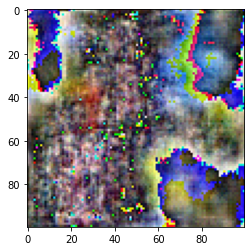

In [41]:
plt.imshow(new_image)




